In [1]:
from IPython.display import HTML

HTML('''
    <script>
        code_show=true; 
        function code_toggle() {
            if (code_show){
                $('div.input').hide();
                $('button#code-toggle').text('Show Code');
            } else {
                $('div.input').show();
                $('button#code-toggle').text('Hide Code');
            }
            code_show = !code_show
        }
    </script>

    <button id="code-toggle" onclick="javascript:code_toggle()">
        Hide Code
    </button>
''')

# Challenge: Make Your Own Multivariate Regression Model

Using the UCR crime dataset, build a regression model to predict property crimes. You can use the features you prepared in the previous assignment, new features of your own choosing, or a combination. The goal here is prediction vs. understanding mechanisms, so focus on creating a model that explains a lot of variance.


In [2]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

pd.options.display.float_format = '{:,.0f}'.format

crime_df = pd.read_excel('./crimes/NY_crimes.xls', header=4)
crime_df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0,nan,0,0,0,12,2,10,0,0
1,Addison Town and Village,"2,577",3,0,nan,0,0,3,24,3,20,1,0
2,Akron Village,"2,846",3,0,nan,0,0,3,16,1,15,0,0
3,Albany,"97,956",791,8,nan,30,227,526,"4,090",705,"3,243",142,nan
4,Albion Village,"6,388",23,0,nan,3,4,16,223,53,165,5,nan


In [3]:
def clean_data(df, state):
    df['Population Sq.'] = df['Population'] ** 2
    df['Robbery Categ'] = np.where(df['Robbery'] > 0, 1, 0)
    df['Murder Categ'] = np.where(df['Murder and\nnonnegligent\nmanslaughter'] > 0, 1, 0)

    arson_text = 'Arson3' if state == 'NY' else 'Arson'
    
    df = df.drop(['Rape\n(revised\ndefinition)1'], axis=1)
    df = df[pd.notnull(df['Population'])]
    df.rename(columns = {'Violent\ncrime': 'Violent crime', 'Murder and\nnonnegligent\nmanslaughter': 'Murder', 'Rape\n(legacy\ndefinition)2':'Rape', 'Aggravated\nassault': 'Assault'}, inplace = True)

    df['Nonviolent crime'] = df['Motor\nvehicle\ntheft'] + df['Larceny-\ntheft'] + df['Burglary'] + df['Property\ncrime'] + df[arson_text]
    df = df.drop(['Motor\nvehicle\ntheft', 'Larceny-\ntheft', 'Burglary', 'Property\ncrime', arson_text], axis=1)

    df['Violent crimes add up'] = df['Violent crime'] == df['Murder'] + df['Rape'] + df['Robbery'] +df['Assault']
    df['More crimes than people'] = df['Violent crime'] > df['Population']

    print('{} rows where violent crimes did not add up'.format(len(df) - np.sum(df['Violent crimes add up'])))
    print('{} rows where more crimes than people'.format(np.sum(df['More crimes than people'])))

    df = df.drop(['Violent crimes add up', 'More crimes than people'], axis=1)
    return df

crime_df = clean_data(crime_df, 'NY')
crime_df.head()

0 rows where violent crimes did not add up
0 rows where more crimes than people


,City,Population,Violent crime,Murder,Rape,Robbery,Assault,Population Sq.,Robbery Categ,Murder Categ,Nonviolent crime
0,Adams Village,"1,861",0,0,0,0,0,"3,463,321",0,0,24
1,Addison Town and Village,"2,577",3,0,0,0,3,"6,640,929",0,0,48
2,Akron Village,"2,846",3,0,0,0,3,"8,099,716",0,0,32
3,Albany,"97,956",791,8,30,227,526,"9,595,377,936",1,1,nan
4,Albion Village,"6,388",23,0,3,4,16,"40,806,544",1,0,nan


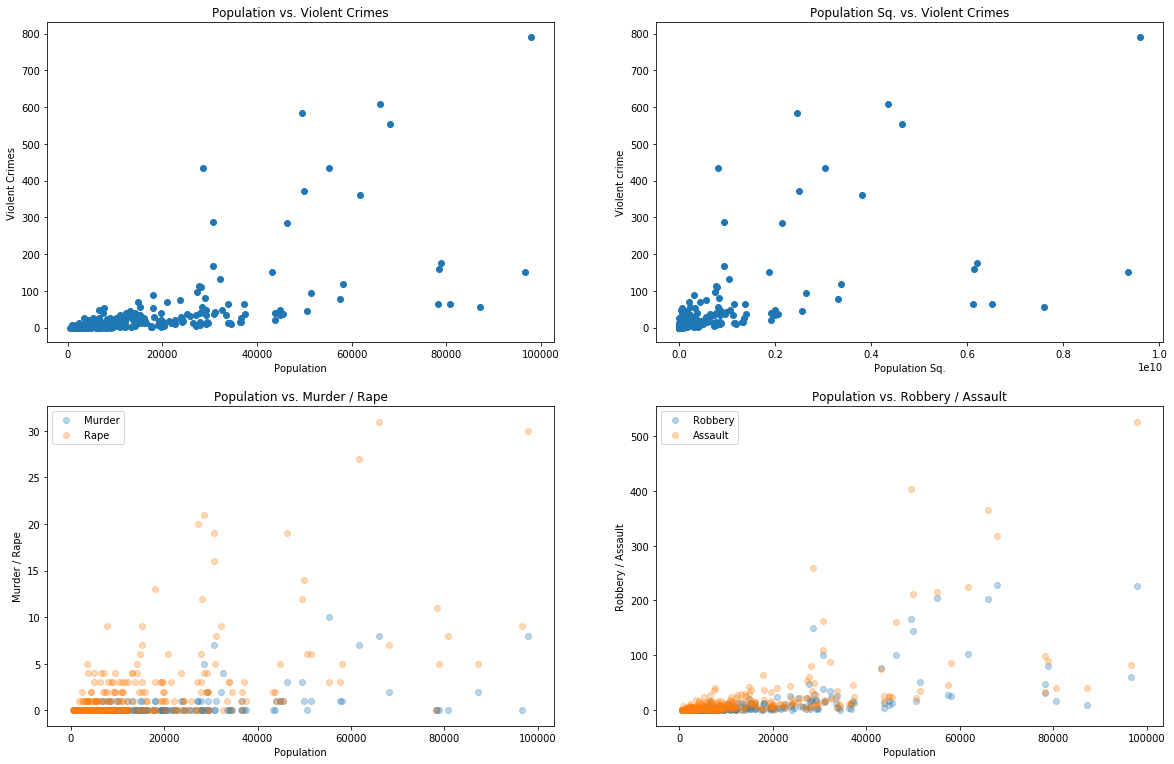

In [4]:
cities_under_outlier_cutoff = crime_df[crime_df['Population'] < 100000]

def display_relevant_plots(df):
    plt.figure(figsize=(20,20))

    plt.subplot(3, 2, 1)
    plt.scatter(df['Population'], df['Violent crime'])
    plt.xlabel('Population')
    plt.ylabel('Violent Crimes')
    plt.title('Population vs. Violent Crimes')

    plt.subplot(3, 2, 2)
    plt.scatter(df['Population Sq.'], df['Violent crime'])
    plt.xlabel('Population Sq.')
    plt.ylabel('Violent crime')
    plt.title('Population Sq. vs. Violent Crimes')

    plt.subplot(3, 2, 3)
    plt.scatter(df['Population'], df['Murder'], alpha=0.3)
    plt.scatter(df['Population'], df['Rape'], alpha=0.3)
    plt.xlabel('Population')
    plt.ylabel('Murder / Rape')
    plt.title('Population vs. Murder / Rape')
    plt.legend(['Murder', 'Rape'])

    plt.subplot(3, 2, 4)
    plt.scatter(df['Population'], df['Robbery'], alpha=0.3)
    plt.scatter(df['Population'], df['Assault'], alpha=0.3)
    plt.xlabel('Population')
    plt.ylabel('Robbery / Assault')
    plt.title('Population vs. Robbery / Assault')
    plt.legend(['Robbery', 'Assault'])

    plt.show()

display_relevant_plots(cities_under_outlier_cutoff)

Next, I will determine where my outliers are.

Lowest Crime Outlier: 53.0
Lowest Murder Outlier: 1.0
Lowest Rape Outlier: 6.0
Lowest Robbery Outlier: 13.0
Lowest Assault Outlier: 34.0
Lowest Population Outlier: 43214.0
Lowest Population Sq. Outlier: 836424241.0


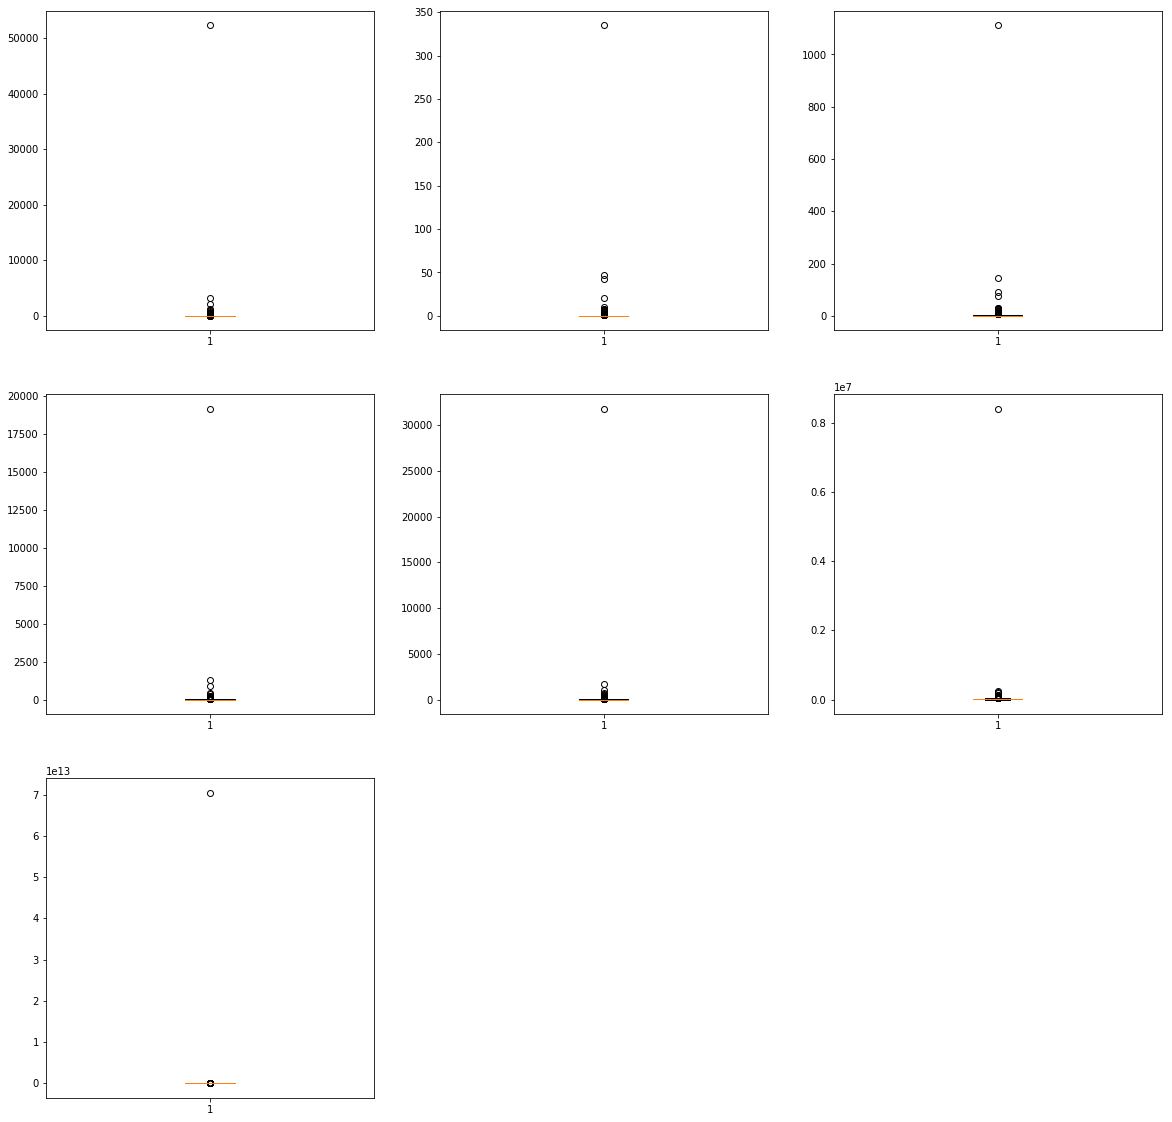

In [5]:
lowest_crime_outlier = 0
lowest_murder_outlier = 0
lowest_rape_outlier = 0
lowest_robbery_outlier = 0
lowest_assault_outlier = 0
lowest_pop_outlier = 0
lowest_pop_sq_outlier = 0

def display_boxplots(df, get_outliers):
    plt.figure(figsize=(20,20))

    plt.subplot(3, 3, 1)
    result = plt.boxplot(df['Violent crime'], showcaps=True)
    if get_outliers & len(result["fliers"]):
        lowest_crime_outlier = result["fliers"][0].get_data()[1].min()
        print('Lowest Crime Outlier: ' + str(lowest_crime_outlier))

    plt.subplot(3, 3, 2)
    result = plt.boxplot(df['Murder'], showcaps=True)
    if get_outliers & len(result["fliers"]):
        lowest_murder_outlier = result["fliers"][0].get_data()[1].min()
        print('Lowest Murder Outlier: ' + str(lowest_murder_outlier))

    plt.subplot(3, 3, 3)
    result = plt.boxplot(df['Rape'], showcaps=True)
    if get_outliers & len(result["fliers"]):
        lowest_rape_outlier = result["fliers"][0].get_data()[1].min()
        print('Lowest Rape Outlier: ' + str(lowest_rape_outlier))

    plt.subplot(3, 3, 4)
    result = plt.boxplot(df['Robbery'], showcaps=True)
    if get_outliers & len(result["fliers"]):
        lowest_robbery_outlier = result["fliers"][0].get_data()[1].min()
        print('Lowest Robbery Outlier: ' + str(lowest_robbery_outlier))

    plt.subplot(3, 3, 5)
    result = plt.boxplot(df['Assault'], showcaps=True)
    if get_outliers & len(result["fliers"]):
        lowest_assault_outlier = result["fliers"][0].get_data()[1].min()
        print('Lowest Assault Outlier: ' + str(lowest_assault_outlier))

    plt.subplot(3, 3, 6)
    result = plt.boxplot(df['Population'], showcaps=True)
    if get_outliers & len(result["fliers"]):
        lowest_pop_outlier = result["fliers"][0].get_data()[1].min()
        print('Lowest Population Outlier: ' + str(lowest_pop_outlier))

    plt.subplot(3, 3, 7)
    result = plt.boxplot(df['Population Sq.'], showcaps=True)
    if get_outliers & len(result["fliers"]):
        lowest_pop_sq_outlier = result["fliers"][0].get_data()[1].min()
        print('Lowest Population Sq. Outlier: ' + str(lowest_pop_sq_outlier))
    
    return {
        "crime": lowest_crime_outlier,
        "murder": lowest_murder_outlier,
        "rape": lowest_rape_outlier,
        "robbery": lowest_robbery_outlier,
        "assault": lowest_assault_outlier,
        "pop": lowest_pop_outlier,
        "pop_sq": lowest_pop_sq_outlier
    } if get_outliers else None

outliers = display_boxplots(crime_df, True)

Now, I will remove these outliers from my dataset and re-examine the data.

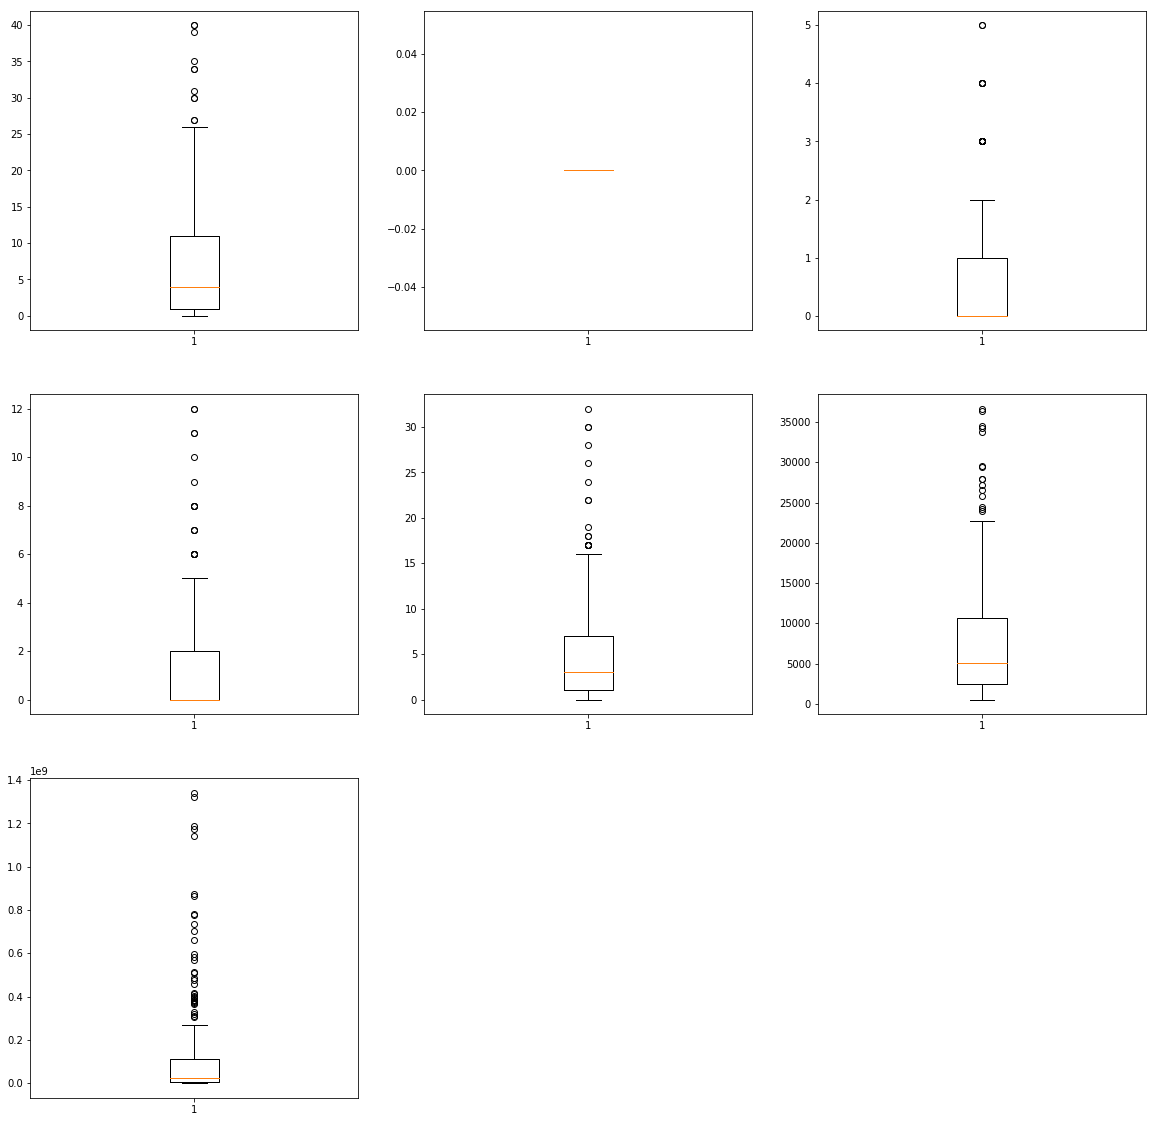

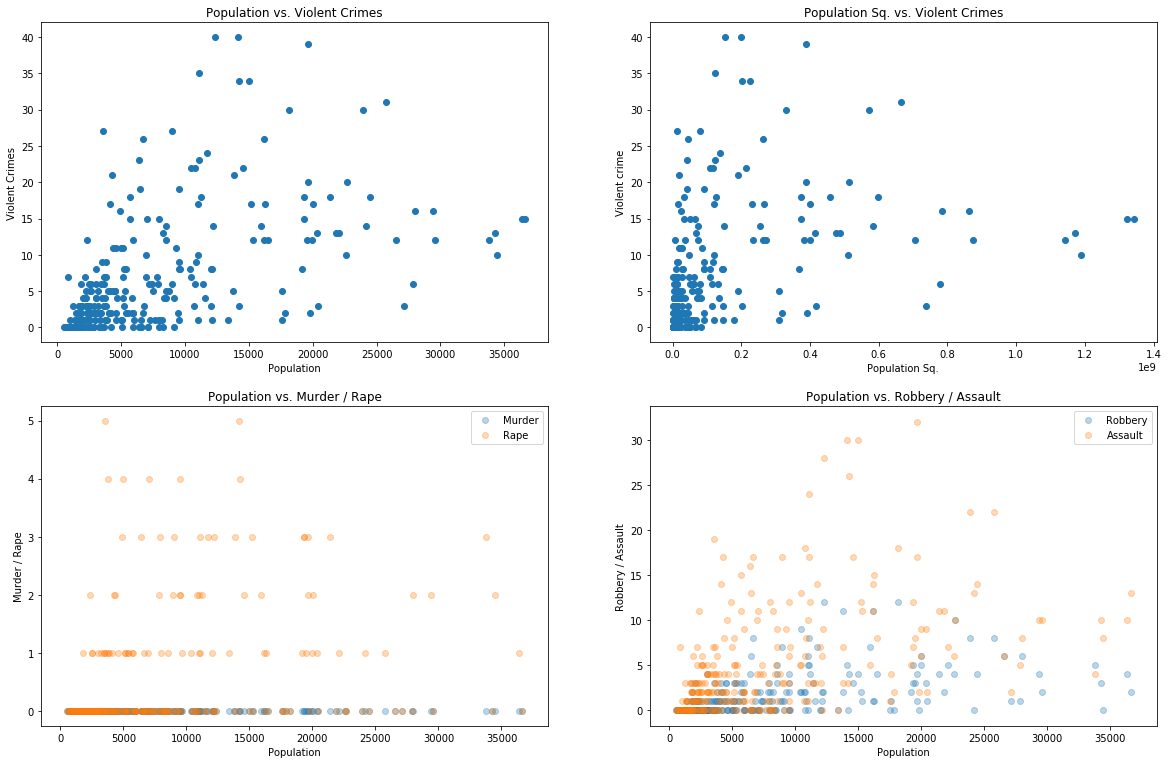

In [6]:
new_df_without_outliers = crime_df[(crime_df['Population'] < outliers['pop']) & (crime_df['Violent crime'] < outliers['crime']) & (crime_df['Murder'] < outliers['murder']) & (crime_df['Rape'] < outliers['rape']) & (crime_df['Robbery'] < outliers['robbery']) & (crime_df['Assault'] < outliers['assault'])]
display_boxplots(new_df_without_outliers, False)

display_relevant_plots(new_df_without_outliers)

## Model

In [7]:
crime_df.head()

,City,Population,Violent crime,Murder,Rape,Robbery,Assault,Population Sq.,Robbery Categ,Murder Categ,Nonviolent crime
0,Adams Village,"1,861",0,0,0,0,0,"3,463,321",0,0,24
1,Addison Town and Village,"2,577",3,0,0,0,3,"6,640,929",0,0,48
2,Akron Village,"2,846",3,0,0,0,3,"8,099,716",0,0,32
3,Albany,"97,956",791,8,30,227,526,"9,595,377,936",1,1,nan
4,Albion Village,"6,388",23,0,3,4,16,"40,806,544",1,0,nan


In [8]:
crime_df = new_df_without_outliers

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = crime_df['Violent crime'].values.reshape(-1, 1)
X = crime_df[['Population', 'Population Sq.', 'Robbery Categ', 'Murder Categ']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 9.74887792e-04 -2.02780624e-08  5.85560499e+00  0.00000000e+00]]

Intercept: 
 [-1.27698365]

R-squared:
0.44377646966613665


## Feature Engineering and Selection Process

Adding a few more features for the regresion model may help make it more accurately predict the outcome (i.e. number of violent crimes).

I will suppose that the number of nonviolent crimes in a city will also help predict how many violent crimes there are.

In [9]:
crime_df = crime_df[pd.notnull(crime_df['Nonviolent crime'])]
crime_df['Nonviolent crime']

0      24
1      48
2      32
6      20
8     421
9     810
10     78
11     66
12      4
13     10
16    176
17    189
19    384
23     28
25      8
26     48
27     40
28     62
29     26
30     22
33     94
34     20
38     92
39    697
42     24
44      4
45    397
46     16
48      8
51    106
       ..
265   114
266    82
268    60
269   320
270    84
277   176
278   142
280    36
283   638
287     0
292    82
293    30
295     0
297    20
300   372
306    49
309   120
311   220
313   634
317    70
319     0
326   156
327   116
328   118
335    50
336   329
337    88
341    72
342   154
344    34
Name: Nonviolent crime, Length: 153, dtype: float64

In [10]:
regr = linear_model.LinearRegression()
Y = crime_df['Violent crime'].values.reshape(-1, 1)
X = crime_df[['Population', 'Population Sq.', 'Nonviolent crime', 'Robbery Categ', 'Murder Categ']]
regr.fit(X, Y)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 3.11387228e-04 -1.22236310e-08  2.13016838e-02  2.12596566e+00
   0.00000000e+00]]

Intercept: 
 [-0.61981622]

R-squared:
0.6776387605466654
